In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from scipy.stats import skew

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [8]:
#Run when executing prediction

from keras.models import load_model
vgg_model = load_model('./vgg16/hydpressure_vgg16.h5')

from keras.preprocessing.image import ImageDataGenerator
image_width = 150
image_height = 150
image_size = (image_width, image_height)
batch_size = 20

C:\Users\USER\Anaconda3\lib\site-packages\keras\engine\saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [4]:
DATA_PATH = "data"
TRAIN_PATH = '%s/train/' % (DATA_PATH)
VALID_PATH = '%s/valid/' % (DATA_PATH)
TEST_PATH = '%s/test/' % (DATA_PATH)

In [2]:
normal_train_ref_data = pd.read_csv('normal_train_ref_data.csv')
normal_train_fbk_data = pd.read_csv('normal_train_fbk_data.csv')
abnormal_train_ref_data = pd.read_csv('abnormal_train_ref_data.csv')
abnormal_train_fbk_data = pd.read_csv('abnormal_train_fbk_data.csv')

normal_valid_ref_data = pd.read_csv('normal_valid_ref_data.csv')
normal_valid_fbk_data = pd.read_csv('normal_valid_fbk_data.csv')
abnormal_valid_ref_data = pd.read_csv('abnormal_valid_ref_data.csv')
abnormal_valid_fbk_data = pd.read_csv('abnormal_valid_fbk_data.csv')

normal_test_ref_data = pd.read_csv('normal_test_ref_data.csv')
normal_test_fbk_data = pd.read_csv('normal_test_fbk_data.csv')
abnormal_test_ref_data = pd.read_csv('abnormal_test_ref_data.csv')
abnormal_test_fbk_data = pd.read_csv('abnormal_test_fbk_data.csv')

## Train Dataframe (Normal + Abnormal)

In [12]:
train_dict = dict()

for i in zip(normal_train_ref_data.columns, normal_train_fbk_data.columns):
    
    a = list(normal_train_ref_data[i[0]][~normal_train_ref_data[i[0]].isna()])
    b = max(a)
    c = a.index(b)
    d = len(a) - a[::-1].index(b)
    e = list(normal_train_fbk_data[i[1]][~normal_train_fbk_data[i[1]].isna()])
    
    unloading_earlier = e[:c]
    loading = e[c:d]
    unloading_latter = e[d:]
    
    for k in [('unloading_earlier', unloading_earlier), ('loading', loading), ('unloading_latter', unloading_latter)]:
        
        for j in [np.min, np.max, np.mean, np.std, kurtosis, skew]:
            function_name = j.__name__
            try:
                train_dict[str(k[0]) + str('_') + str(function_name)] = train_dict[str(k[0]) + str('_') + str(function_name)] + [round(j(k[1]),3)]
            except:
                train_dict.update({str(k[0]) + str('_') + str(function_name) : [round(np.mean(k[1]),3)]})

        for j in [25,50,75]:
            try:
                train_dict[str(k[0]) + '_percentile' + str(j)] = train_dict[str(k[0]) + '_percentile' + str(j)] + [round(np.percentile(k[1],j),3)]
            except:
                train_dict.update({str(k[0]) + '_percentile' + str(j) : [round(np.percentile(k[1],j),3)]})
                
normal_train_df = pd.DataFrame(train_dict)
normal_train_df['condition'] = 0

In [13]:
train_dict = dict()

for i in zip(abnormal_train_ref_data.columns, abnormal_train_fbk_data.columns):
    
    a = list(abnormal_train_ref_data[i[0]][~abnormal_train_ref_data[i[0]].isna()])
    b = max(a)
    c = a.index(b)
    d = len(a) - a[::-1].index(b)
    e = list(abnormal_train_fbk_data[i[1]][~abnormal_train_fbk_data[i[1]].isna()])
    
    unloading_earlier = e[:c]
    loading = e[c:d]
    unloading_latter = e[d:]
    
    for k in [('unloading_earlier', unloading_earlier), ('loading', loading), ('unloading_latter', unloading_latter)]:
        
        for j in [np.min, np.max, np.mean, np.std, kurtosis, skew]:
            function_name = j.__name__
            try:
                train_dict[str(k[0]) + str('_') + str(function_name)] = train_dict[str(k[0]) + str('_') + str(function_name)] + [round(j(k[1]),3)]
            except:
                train_dict.update({str(k[0]) + str('_') + str(function_name) : [round(np.mean(k[1]),3)]})

        for j in [25,50,75]:
            try:
                train_dict[str(k[0]) + '_percentile' + str(j)] = train_dict[str(k[0]) + '_percentile' + str(j)] + [round(np.percentile(k[1],j),3)]
            except:
                train_dict.update({str(k[0]) + '_percentile' + str(j) : [round(np.percentile(k[1],j),3)]})
                
abnormal_train_df = pd.DataFrame(train_dict)
abnormal_train_df['condition'] = 1

In [14]:
train_df = pd.concat([normal_train_df, abnormal_train_df])
train_X = np.array(train_df.iloc[:,:-1])
train_Y = np.array(train_df.iloc[:,-1])

## Valid Dataframe

In [15]:
valid_dict = dict()

for i in zip(normal_valid_ref_data.columns, normal_valid_fbk_data.columns):
    
    a = list(normal_valid_ref_data[i[0]][~normal_valid_ref_data[i[0]].isna()])
    b = max(a)
    c = a.index(b)
    d = len(a) - a[::-1].index(b)
    e = list(normal_valid_fbk_data[i[1]][~normal_valid_fbk_data[i[1]].isna()])
    
    unloading_earlier = e[:c]
    loading = e[c:d]
    unloading_latter = e[d:]
    
    for k in [('unloading_earlier', unloading_earlier), ('loading', loading), ('unloading_latter', unloading_latter)]:
        
        for j in [np.min, np.max, np.mean, np.std, kurtosis, skew]:
            function_name = j.__name__
            try:
                valid_dict[str(k[0]) + str('_') + str(function_name)] = valid_dict[str(k[0]) + str('_') + str(function_name)] + [round(j(k[1]),3)]
            except:
                valid_dict.update({str(k[0]) + str('_') + str(function_name) : [round(np.mean(k[1]),3)]})

        for j in [25,50,75]:
            try:
                valid_dict[str(k[0]) + '_percentile' + str(j)] = valid_dict[str(k[0]) + '_percentile' + str(j)] + [round(np.percentile(k[1],j),3)]
            except:
                valid_dict.update({str(k[0]) + '_percentile' + str(j) : [round(np.percentile(k[1],j),3)]})
                
normal_valid_df = pd.DataFrame(valid_dict)
normal_valid_df['condition'] = 0

In [16]:
valid_dict = dict()

for i in zip(abnormal_valid_ref_data.columns, abnormal_valid_fbk_data.columns):
    
    a = list(abnormal_valid_ref_data[i[0]][~abnormal_valid_ref_data[i[0]].isna()])
    b = max(a)
    c = a.index(b)
    d = len(a) - a[::-1].index(b)
    e = list(abnormal_valid_fbk_data[i[1]][~abnormal_valid_fbk_data[i[1]].isna()])
    
    unloading_earlier = e[:c]
    loading = e[c:d]
    unloading_latter = e[d:]
    
    for k in [('unloading_earlier', unloading_earlier), ('loading', loading), ('unloading_latter', unloading_latter)]:
        
        for j in [np.min, np.max, np.mean, np.std, kurtosis, skew]:
            function_name = j.__name__
            try:
                valid_dict[str(k[0]) + str('_') + str(function_name)] = valid_dict[str(k[0]) + str('_') + str(function_name)] + [round(j(k[1]),3)]
            except:
                valid_dict.update({str(k[0]) + str('_') + str(function_name) : [round(np.mean(k[1]),3)]})

        for j in [25,50,75]:
            try:
                valid_dict[str(k[0]) + '_percentile' + str(j)] = valid_dict[str(k[0]) + '_percentile' + str(j)] + [round(np.percentile(k[1],j),3)]
            except:
                valid_dict.update({str(k[0]) + '_percentile' + str(j) : [round(np.percentile(k[1],j),3)]})
                
abnormal_valid_df = pd.DataFrame(valid_dict)
abnormal_valid_df['condition'] = 1

In [17]:
valid_df = pd.concat([normal_valid_df, abnormal_valid_df])
valid_X = np.array(valid_df.iloc[:,:-1])
valid_Y = np.array(valid_df.iloc[:,-1])

## Test Dataframe

In [18]:
test_dict = dict()

for i in zip(normal_test_ref_data.columns, normal_test_fbk_data.columns):
    
    a = list(normal_test_ref_data[i[0]][~normal_test_ref_data[i[0]].isna()])
    b = max(a)
    c = a.index(b)
    d = len(a) - a[::-1].index(b)
    e = list(normal_test_fbk_data[i[1]][~normal_test_fbk_data[i[1]].isna()])
    
    unloading_earlier = e[:c]
    loading = e[c:d]
    unloading_latter = e[d:]
    
    for k in [('unloading_earlier', unloading_earlier), ('loading', loading), ('unloading_latter', unloading_latter)]:
        
        for j in [np.min, np.max, np.mean, np.std, kurtosis, skew]:
            function_name = j.__name__
            try:
                test_dict[str(k[0]) + str('_') + str(function_name)] = test_dict[str(k[0]) + str('_') + str(function_name)] + [round(j(k[1]),3)]
            except:
                test_dict.update({str(k[0]) + str('_') + str(function_name) : [round(np.mean(k[1]),3)]})

        for j in [25,50,75]:
            try:
                test_dict[str(k[0]) + '_percentile' + str(j)] = test_dict[str(k[0]) + '_percentile' + str(j)] + [round(np.percentile(k[1],j),3)]
            except:
                test_dict.update({str(k[0]) + '_percentile' + str(j) : [round(np.percentile(k[1],j),3)]})
                
normal_test_df = pd.DataFrame(test_dict)
normal_test_df['condition'] = 0

In [19]:
test_dict = dict()

for i in zip(abnormal_test_ref_data.columns, abnormal_test_fbk_data.columns):
    
    a = list(abnormal_test_ref_data[i[0]][~abnormal_test_ref_data[i[0]].isna()])
    b = max(a)
    c = a.index(b)
    d = len(a) - a[::-1].index(b)
    e = list(abnormal_test_fbk_data[i[1]][~abnormal_test_fbk_data[i[1]].isna()])
    
    unloading_earlier = e[:c]
    loading = e[c:d]
    unloading_latter = e[d:]
    
    for k in [('unloading_earlier', unloading_earlier), ('loading', loading), ('unloading_latter', unloading_latter)]:
        
        for j in [np.min, np.max, np.mean, np.std, kurtosis, skew]:
            function_name = j.__name__
            try:
                test_dict[str(k[0]) + str('_') + str(function_name)] = test_dict[str(k[0]) + str('_') + str(function_name)] + [round(j(k[1]),3)]
            except:
                test_dict.update({str(k[0]) + str('_') + str(function_name) : [round(np.mean(k[1]),3)]})

        for j in [25,50,75]:
            try:
                test_dict[str(k[0]) + '_percentile' + str(j)] = test_dict[str(k[0]) + '_percentile' + str(j)] + [round(np.percentile(k[1],j),3)]
            except:
                test_dict.update({str(k[0]) + '_percentile' + str(j) : [round(np.percentile(k[1],j),3)]})
                
abnormal_test_df = pd.DataFrame(test_dict)
abnormal_test_df['condition'] = 1

In [20]:
test_df = pd.concat([normal_test_df, abnormal_test_df])
test_X = np.array(test_df.iloc[:,:-1])
test_Y = np.array(test_df.iloc[:,-1])

## VGG16

In [26]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [27]:
vgg_model = Sequential()
vgg_model.add(conv_base)
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dense(1, activation='sigmoid'))

In [28]:
conv_base.trainable = False

In [10]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 150
image_height = 150
image_size = (image_width, image_height)
batch_size = 20

In [31]:
train_datagen = ImageDataGenerator(rescale=1.0/255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAIN_PATH,target_size=image_size,batch_size=batch_size,class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(VALID_PATH,target_size=image_size,batch_size=batch_size,class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [32]:
vgg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model = ModelCheckpoint("./vgg16/hydpressure_vgg16.h5", monitor='val_loss', verbose=0, save_best_only=True)

history = vgg_model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            validation_steps=8,
            epochs=10,
            validation_data=validation_generator,
            callbacks=[best_model, TensorBoard(log_dir='./vgg16/logs')])

Epoch 1/10
100/100 [==============================] - 920s 9s/step - loss: 0.2938 - acc: 0.8830 - val_loss: 0.1489 - val_acc: 0.9475
Epoch 2/10
100/100 [==============================] - 971s 10s/step - loss: 0.1969 - acc: 0.9245 - val_loss: 0.0898 - val_acc: 0.9675
Epoch 3/10
100/100 [==============================] - 710s 7s/step - loss: 0.2006 - acc: 0.9260 - val_loss: 0.0824 - val_acc: 0.9750
Epoch 4/10
100/100 [==============================] - 647s 6s/step - loss: 0.2123 - acc: 0.9190 - val_loss: 0.1121 - val_acc: 0.9575
Epoch 5/10
100/100 [==============================] - 644s 6s/step - loss: 0.1646 - acc: 0.9430 - val_loss: 0.0777 - val_acc: 0.9750
Epoch 6/10
100/100 [==============================] - 642s 6s/step - loss: 0.1570 - acc: 0.9480 - val_loss: 0.1334 - val_acc: 0.9500
Epoch 7/10
100/100 [==============================] - 647s 6s/step - loss: 0.1599 - acc: 0.9345 - val_loss: 0.0829 - val_acc: 0.9725
Epoch 8/10
100/100 [==============================] - 717s 7s/step -

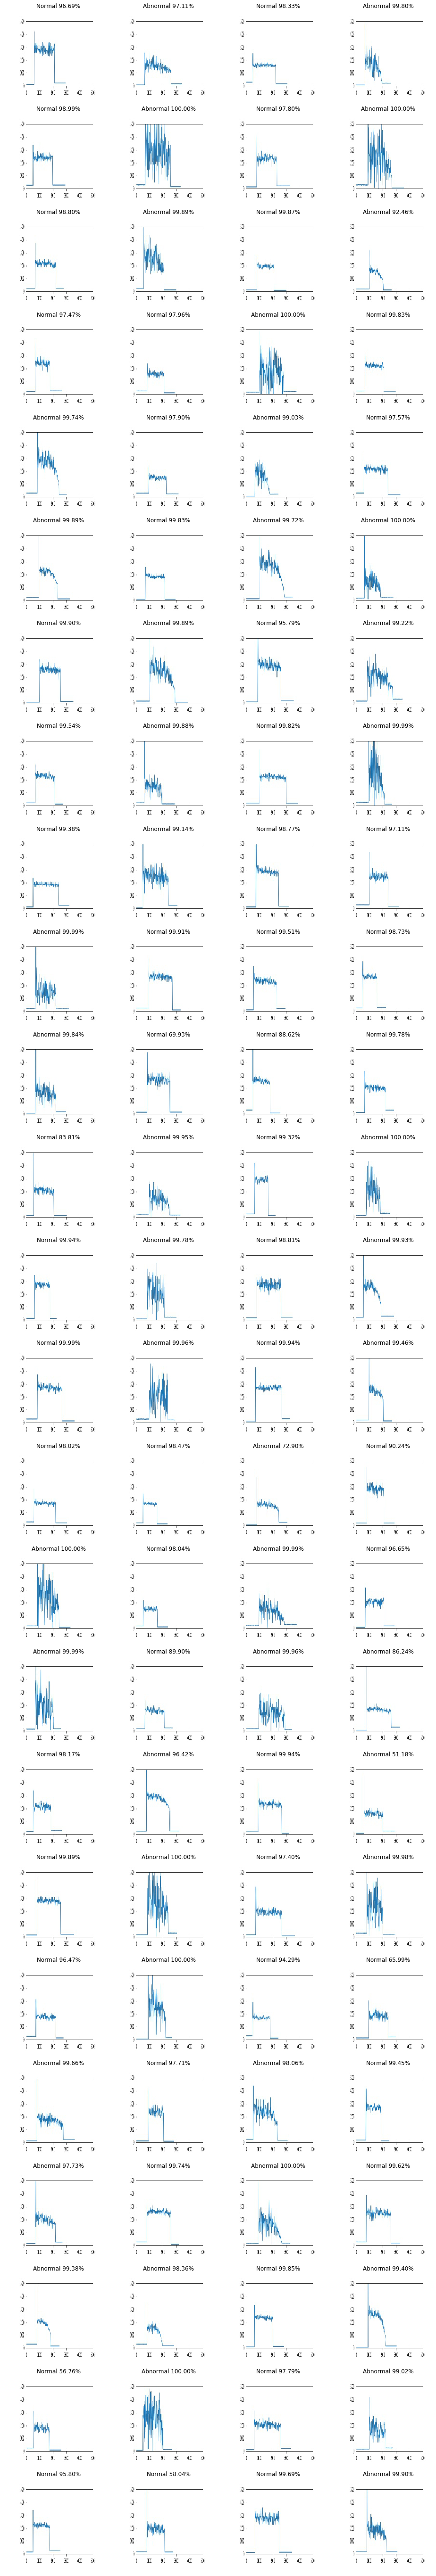

In [14]:
from operator import itemgetter
import re
import os
from keras.preprocessing.image import load_img, img_to_array

test_images  = os.listdir(TEST_PATH)

def preprocess_image(img_path):
    img = load_img(img_path, target_size=image_size)
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor

result = []

plt.figure(figsize=(16, 200))
for index, image in enumerate(test_images):
    img = preprocess_image(TEST_PATH + image)
    
    prediction = vgg_model.predict(img)[0]
    
    plt.subplot(50, 4, index+1)
    if prediction < 0.5:
        plt.title('Abnormal %.2f%%' % (100 - prediction*100))
        result.append('Abnormal')
    else:
        plt.title('Normal %.2f%%' % (prediction*100))
        result.append('Normal')
    
    plt.axis('off')
    plt.imshow(img[0])